Training a Feed Forward Neural Network on Google Colab TPU
----

This notebook fits a deep feed-forward neural network.

After some trial and error, arrived at two key elements:
1. The data needs to be normalized.
1. Using dropout layers for regularization.



# Setup

## Imports

In [1]:
import sys
import os
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from typing import Tuple, Union, List
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from google.colab import drive, runtime
# sys.path.append("../src")

## Mounting Drive

In [2]:
drive_root = '/gdrive'
drive.mount(drive_root)
project_folder = drive_root + '/My Drive/learning/Data Science/Springboard/Capstone Projects/2/rnn'
train_data_path = project_folder + '/tx_train_balanced.csv'
test_data_path = project_folder + '/tx_test.csv'
mcc_rates_path = project_folder + '/mcc_rates.csv'
output_path = project_folder + '/fraud_prediction_ffnn.h5'
log_path = project_folder + '/training_logs'

def save_log(log_note:str, model_summary, history):
    current_time = datetime.now().strftime('%Y%m%d%H%M%S')
    validation = pd.DataFrame({key:val for key, val in history.items() if key.startswith('val_')})
    training = pd.DataFrame({key:val for key, val in history.items() if key not in validation.columns})
    with open(log_path+f'/{current_time}.txt', mode='w') as f:
        f.write(log_note +'\n')
        model_summary(print_fn=lambda l: f.write(l+'\n'))
        f.write(str(training)+'\n'+str(validation))

Mounted at /gdrive


## TPU setup

In [3]:
tf.keras.backend.clear_session()

resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
# or: tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
tf.config.experimental_connect_to_cluster(resolver)

# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


# Preprocessing

## Transformer classes

In [4]:
def convert_multicat(df: pd.DataFrame, colname: str, copy:bool=True) -> Tuple[pd.DataFrame, List[str]]:
    '''(Optionally copies `df` and) converts the categorical column `colname` into dummies. Allows for membership in multiple categories separated by a single comma, e.g. entry "a,b" will be converted into `True` for columns `a` and `b`'''
    if copy:
        dummy_df = df.copy()
    else:
        dummy_df = df
    cats = set()
    for entry in dummy_df[colname].dropna().unique().tolist():
        for cat in entry.split(','):
            cats.add(cat)
    cats = list(cats)
    for cat in cats:
        dummy_df[cat] = dummy_df[colname].str.contains(cat).fillna(False)
    dummy_df.drop(columns=colname, inplace=True)

    return dummy_df, cats



class MakeDummies(BaseEstimator, TransformerMixin):
    """Transforms categorical columns into dummies. Can handle multi-category columns"""
    def __init__(self, multicat_col: str, drop_first=True, dummy_cols:Union[List[str], str]='auto') -> None:
        super().__init__()
        self.multicat_col = multicat_col
        self.drop_first = drop_first
        self.dummy_cols= dummy_cols

    def fit(self, X, y=None):
        _, self.cats = convert_multicat(X, self.multicat_col)
        return self

    def fit_transform(self, X, y=None):
        dummy_df, self.cats = convert_multicat(X, self.multicat_col)
        dummy_df = pd.get_dummies(dummy_df, drop_first=self.drop_first)
        return dummy_df

    def transform(self, X, y=None):
        dummy_df = X.copy()
        for cat in self.cats:
            dummy_df[cat] = dummy_df[self.multicat_col].str.contains(cat).fillna(False)
        dummy_df.drop(columns=self.multicat_col, inplace=True)
        dummy_df = pd.get_dummies(dummy_df, drop_first=self.drop_first)

        return dummy_df



class MCCRates(BaseEstimator, TransformerMixin):
    """Transforms MCC codes into average fraud rates, based on saved data or a specific training set. Note: only accepts data frames"""

    mcc_rates_path = mcc_rates_path

    def __init__(self, use_saved=None) -> None:
        super().__init__()
        self.mcc_rates = pd.read_csv(use_saved, index_col=0) if use_saved else None

    def fit(self, X, y=None):
        if self.mcc_rates is None:
            self.mcc_rates = (
                X.copy()
                .groupby('mcc')
                .agg('mean')
                .rename({'mean':'mcc_fraud_rate'}, axis=1)
            )
        return self

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def transform(self, X, y=None):
        X_transformed = X.merge(self.mcc_rates, how='left', left_on='mcc', right_index=True)
        X_transformed.drop(columns='mcc', inplace=True)
        return X_transformed

## Loading data

In [5]:
# load balanced training data and test data
training_data_raw = pd.read_csv(train_data_path, index_col=0)
testing_data_raw = pd.read_csv(test_data_path, index_col=0)

print(training_data_raw.head(3).T)

                                7977       7979       7987
user                               5          5          5
card                               0          0          0
amount                         11.45      471.0     398.93
mcc                             5311       3504       3504
errors                           NaN        NaN        NaN
is_fraud                        True       True       True
tx_type                       online     online     online
card_brand                      Visa       Visa       Visa
card_type                     Credit     Credit     Credit
has_chip                        True       True       True
cards_issued                       2          2          2
credit_limit                  9900.0     9900.0     9900.0
gender                          Male       Male       Male
latitude                       41.55      41.55      41.55
longitude                      -90.6      -90.6      -90.6
per_capita_income_zipcode    20599.0    20599.0    20599

## Processing data

In [6]:
val_source = "test" # @param ['test', 'train']
val_share = 0.1 # @param {type: "slider", min:0, max:1, step:0.05}

mcc_converter = MCCRates(mcc_rates_path)
dummy_converter = MakeDummies('errors')
normalizer = StandardScaler()

if val_source == 'train':
    X_train, X_val, y_train, y_val = train_test_split(
        training_data_raw.drop(columns=['is_fraud', 'card', 'user']),
        training_data_raw.is_fraud,
        test_size=val_share,
        stratify=training_data_raw.is_fraud
    )
    y_test = testing_data_raw.is_fraud
    X_test = testing_data_raw.drop(columns=['is_fraud','card', 'user'])
else:
    X_test, X_val, y_test, y_val = train_test_split(
        testing_data_raw.drop(columns=['is_fraud', 'card', 'user']),
        testing_data_raw.is_fraud,
        test_size=val_share,
        stratify=testing_data_raw.is_fraud
    )
    y_train = training_data_raw.is_fraud
    X_train = training_data_raw.drop(columns=['is_fraud','card', 'user'])

y_train = y_train.to_numpy(dtype=np.float32, copy=True)
X_train = mcc_converter.fit_transform(X_train)
X_train = dummy_converter.fit_transform(X_train)
print("Transformed data:\n", X_train.head(3).T)
X_train = normalizer.fit_transform(X_train.to_numpy()).astype(np.float32)

y_val = y_val.to_numpy(dtype=np.float32, copy=True)
X_val = mcc_converter.transform(X_val)
X_val = dummy_converter.transform(X_val)
X_val = normalizer.transform(X_val.to_numpy()).astype(np.float32)

y_test = y_test.to_numpy(dtype=np.float32, copy=True)
X_test = mcc_converter.transform(X_test)
X_test = dummy_converter.transform(X_test)
X_test = normalizer.transform(X_test.to_numpy()).astype(np.float32)

# positive_training_share = np.sum(y_train) / np.product(y_train.shape)
# training_weights = np.where(y_train==1., 1./positive_training_share, 1.).astype(np.float32)

Transformed data:
                                 7977       7979       7987
amount                         11.45      471.0     398.93
has_chip                        True       True       True
cards_issued                       2          2          2
credit_limit                  9900.0     9900.0     9900.0
latitude                       41.55      41.55      41.55
longitude                      -90.6      -90.6      -90.6
per_capita_income_zipcode    20599.0    20599.0    20599.0
yearly_income_person         41997.0    41997.0    41997.0
total_debt                       0.0        0.0        0.0
fico_score                       704        704        704
num_credit_cards                   3          3          3
home_city                      False      False      False
home_state                     False      False      False
home_zip                       False      False      False
overseas                       False      False      False
user_age                   38.523288 

In [7]:
print("Training", "Validation", "Testing")
print(X_train.shape, y_train.shape, '|', X_val.shape, y_val.shape, '|', X_test.shape, y_test.shape)
print(y_train.sum(), y_val.sum(), y_test.sum())
print("First training observation and label:", X_train[0,:], X_train.dtype, y_train[0], y_train.dtype)
print("First training observation and label:", X_val[0,:], X_val.dtype, y_val[0], y_val.dtype)

Training Validation Testing
(27599, 35) (27599,) | (117671, 35) (117671,) | (1059036, 35) (1059036,)
13850.0 142.0 1273.0
First training observation and label: [-0.41552633  0.3045107   0.9016859  -0.37503085  0.8631322   0.03799457
 -0.20152299 -0.08792743 -1.1426392  -0.14557597 -0.59956527 -0.6455337
 -0.92420155 -0.5870714  -0.3603558  -0.5948774  -0.4367393  -0.6679103
  1.8498534  -0.08417551 -0.04589064 -0.11068034 -0.06905929 -0.08011223
 -0.0426022  -0.04427673 -0.00851303  1.3233937  -0.8446766  -0.16941158
 -1.0362748   1.2562408  -1.2314827  -0.30924615  1.0394379 ] float32 1.0 float32
First training observation and label: [ 0.12559287  0.3045107   0.9016859   0.06197695 -0.9446695  -0.52858967
 -0.60025316 -0.63901263 -0.7283031  -0.7039998   0.02041981  1.5491059
  1.082015    1.7033702  -0.3603558   0.51351964 -0.4367393   0.15453242
 -1.0119652  -0.18349896 -0.04589064 -0.11068034 -0.06905929 -0.08011223
 -0.0426022  -0.04427673 -0.00851303 -0.75563306  1.183885   -0.16

In [8]:
multiplier = 64
batch_size = multiplier * strategy.num_replicas_in_sync
print(f"Batch size: {multiplier}*{strategy.num_replicas_in_sync}={batch_size}")

n_train, num_cols = X_train.shape

# data_tuple = (X_train, y_train, training_weights) # when not using weighting by loss function
def tensor_tuple(*data):
    return tuple(tf.convert_to_tensor(a) for a in data)

training_data = (
                tf.data.Dataset.from_tensor_slices(tensor_tuple(X_train, y_train))
                    .shuffle(n_train)
                    .repeat()
                    .batch(batch_size, drop_remainder=True)
)

Batch size: 64*8=512


# Model setup

In [9]:
def create_model(
    width, depth, # hidden layer dimensions
    activation, hinge_loss, # activation and loss
    kernel_l1, kernel_l2, bias_l1, bias_l2, # weight regularization
    dropout, gn, batchnorm, # normalization/noise
    num_cols=num_cols # input shape
):
    model = keras.models.Sequential()

    model.add(keras.layers.Input(shape=num_cols))
    model.add(keras.layers.GaussianNoise(gn))
    # model.add(keras.layers.GaussianNoise(0.1))

    # adds depth dense layers, of size width
    for _ in range(depth):
        kernel_regularizer=keras.regularizers.L1L2(l1=kernel_l1, l2=kernel_l2)
        bias_regularizer=keras.regularizers.L1L2(l1=bias_l1, l2=bias_l2)
        model.add(keras.layers.Dense(
            width,
            activation=None,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer
        ))

        if batchnorm:
            model.add(keras.layers.BatchNormalization())

        model.add(keras.layers.Activation(activation))

        if dropout >= 0.01:
            model.add(keras.layers.Dropout(rate=dropout))

    # model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.add(keras.layers.Dense(1, activation=None)) # "logit" results

    if hinge_loss:
        loss = keras.losses.Hinge()
    else:
        loss = keras.losses.BinaryCrossentropy(from_logits=True)

    pr_auc = keras.metrics.AUC(curve='PR', name="pr_auc", from_logits=True)

    model.compile(
        optimizer='adam',
        loss=loss,
        metrics=[pr_auc]
    )
    return model



# Training

In [10]:
model_params = {
    'width': 128,
    'depth': 3,
    'activation': 'relu',
    'hinge_loss': False,
    'kernel_l1': 0.,
    'kernel_l2': 0.002,
    'bias_l1': 0.,
    'bias_l2': 0.04,
    'dropout': 0.4,
    'gn': 0.82,
    'batchnorm': True,
    'num_cols': num_cols
}

with strategy.scope():
    model = create_model(**model_params)

epochs = 30 # @param {type:"slider", min:0, max:100, step:5}
save_model = False # @param {type:"boolean"}

print(model.summary())
training_history = model.fit(
    training_data,
    steps_per_epoch=n_train//batch_size,
    validation_data=(X_val, y_val),
    validation_batch_size=batch_size,
    validation_freq=2,
    epochs=epochs
)

save_log(str(model_params), model.summary, training_history.history)

if save_model:
    model.save_weights(output_path, overwrite=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 35)               0         
 se)                                                             
                                                                 
 dense (Dense)               (None, 128)               4608      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               1

# Evaluation

In [11]:
def predict_prob(model, X):
    raw_pred = model.predict(X, batch_size=batch_size).reshape(-1)
    return 1 / (1 + np.exp(-raw_pred))

In [12]:
y_pred, y_pred_train, y_pred_val = (predict_prob(model, X) for X in (X_test, X_train, X_val))

230/230 [==============================] - 3s 10ms/step


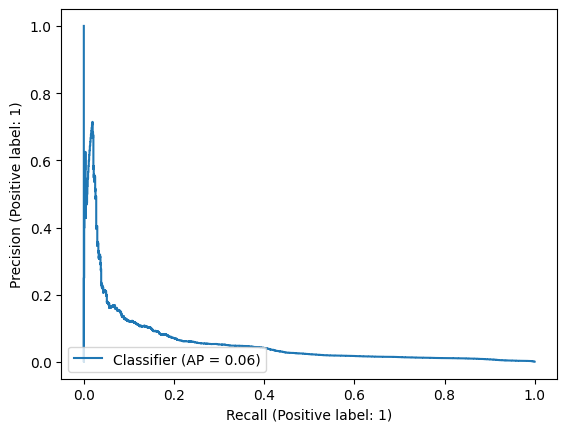

In [13]:
from sklearn.metrics import PrecisionRecallDisplay
p_r_curve = PrecisionRecallDisplay.from_predictions(y_test, y_pred)
# plt.axis((0., 1., 0., 0.25));

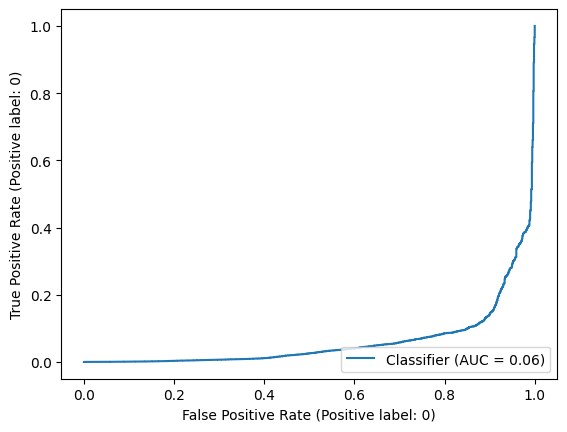

In [14]:
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_predictions(y_test, y_pred, pos_label=0)

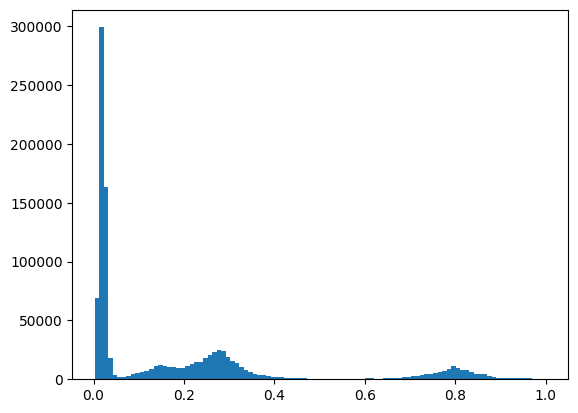

In [15]:
plt.hist(y_pred, bins=100);

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

sorted_idx = np.argsort(y_pred)
fixed_label = np.zeros_like(y_pred)
fixed_label[-int(2*np.sum(y_test)):] = 1
print(classification_report(y_test[sorted_idx], fixed_label))
print(confusion_matrix(y_test[sorted_idx], fixed_label))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1057763
         1.0       0.08      0.17      0.11      1273

    accuracy                           1.00   1059036
   macro avg       0.54      0.58      0.56   1059036
weighted avg       1.00      1.00      1.00   1059036

[[1055431    2332]
 [   1059     214]]


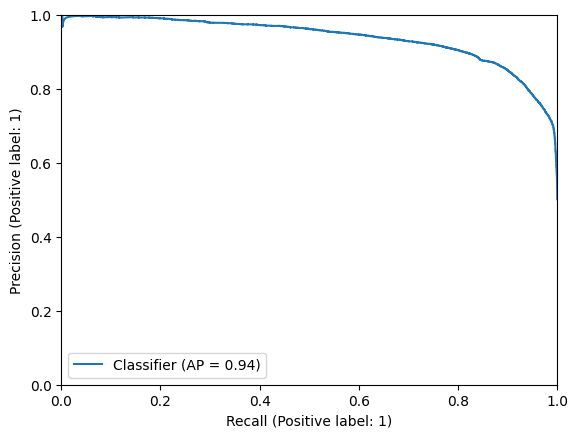

In [17]:
# y_pred_train = model.predict(X_train).reshape(-1)
p_r_curve_train = PrecisionRecallDisplay.from_predictions(y_train, y_pred_train)
plt.axis((0., 1., 0., 1));

In [18]:
print(classification_report(y_train, np.where(y_pred_train>0.5,1.,0.)))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87     13749
         1.0       0.88      0.85      0.86     13850

    accuracy                           0.86     27599
   macro avg       0.86      0.86      0.86     27599
weighted avg       0.87      0.86      0.86     27599



              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94    117529
         1.0       0.01      0.90      0.02       142

    accuracy                           0.88    117671
   macro avg       0.50      0.89      0.48    117671
weighted avg       1.00      0.88      0.94    117671



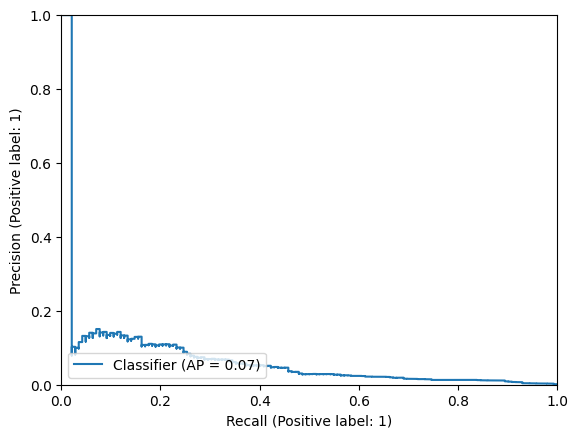

In [19]:
# y_pred_val = model.predict(X_val).reshape(-1)
print(classification_report(y_val, np.where(y_pred_val>0.5,1.,0.)))
p_r_curve_val = PrecisionRecallDisplay.from_predictions(y_val, y_pred_val)
plt.axis((0., 1., 0., 1));

In [ ]:
unmount = False # @param {type:"boolean"}
if unmount:
    drive.flush_and_unmount()
    runtime.unassign()